<ol>
<li>Historical Prices
	<ul>
	<li>Open Price: The price at which a stock starts trading when the market opens.</li>
	<li>High Price: The highest price at which a stock traded during a specific period.</li>
	<li>Low Price: The lowest price at which a stock traded during a specific period.</li>
	<li>Close Price: The final price at which a stock is traded on a given trading day.</li>
	<li>Volume: The number of shares traded during a specific period.</li>
	</ul></li>

<li>Technical Indicators
    <ul>
	<li> Moving Averages: Simple Moving Average (SMA), Exponential Moving Average (EMA), etc., which smooth out price data to identify trends.</li>
	<li> Relative Strength Index (RSI): A momentum oscillator that measures the speed and change of price movements.</li>
	<li> Moving Average Convergence Divergence (MACD): A trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price.</li>
	<li> Bollinger Bands: A volatility indicator that consists of a middle band (moving average) and two outer bands (standard deviations away from the middle band).</li>
	<li> Stochastic Oscillator: A momentum indicator comparing a particular closing price to a range of its prices over a certain period.</li>
	</ul>
	</li>
</ol>

In [33]:
from dateutil.relativedelta import relativedelta
from dotenv import dotenv_values
import requests
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayushrajsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayushrajsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayushrajsingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
config = dotenv_values(".env")

In [35]:
def fetch_news(api_key, query, start_date, end_date):
    url = f'https://newsapi.org/v2/everything?q={query}&from={start_date}&to={end_date}&apiKey={api_key}'
    response = requests.get(url)
    news_data = response.json()
    return news_data['articles']

In [36]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [37]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [38]:
def get_sentiment_ratio(data):
    sentiment_percentage = 0
    sentiment = 'Neutral'
    data['sentiment'] = data['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
    positive_sentiment = len(data[data['sentiment']=='Positive'])
    negative_sentiment = len(data[data['sentiment']=='Negative'])
    total_sentiment = positive_sentiment + negative_sentiment
    if(positive_sentiment > negative_sentiment):
        sentiment_percentage = (positive_sentiment / total_sentiment) * 100
        sentiment = 'Positive'
    elif(negative_sentiment > positive_sentiment):
        sentiment_percentage = (negative_sentiment / total_sentiment) * 100
        sentiment = 'Negative'
    return sentiment, sentiment_percentage

In [39]:
def fetch_data(ticker, start_date, end_date):
    stock_data = yf.download(tickers=ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    return stock_data

In [40]:
def prepare_data(data, feature_cols, target_col):
    input_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_inputs = input_scaler.fit_transform(data[feature_cols])
    scaled_target = target_scaler.fit_transform(data[[target_col]])
    return scaled_inputs, scaled_target, input_scaler, target_scaler

In [41]:
def calculate_sma(data, window=20):
    data[f'SMA_{window}'] = data['Close'].rolling(window=window).mean()
    return data

In [42]:
def calculate_ema(data, window=20):
    data[f'EMA_{window}'] = data['Close'].ewm(span=window, adjust=False).mean()
    return data

In [43]:
def calculate_rsi(data, period=14):
    data['Change'] = data['Close'].diff()
    
    data['Gain'] = data['Change'].apply(lambda x: max(x, 0))
    data['Loss'] = data['Change'].apply(lambda x: -min(x, 0))
    
    data['Average Gain'] = data['Gain'].rolling(window=period, min_periods=1).mean()
    data['Average Loss'] = data['Loss'].rolling(window=period, min_periods=1).mean()
    
    data['RS'] = data['Average Gain'] / data['Average Loss']
    
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    
    data = data.drop(columns=['Change', 'Gain', 'Loss', 'Average Gain', 'Average Loss', 'RS'])
    
    return data


In [44]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA_short'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_long'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_short'] - data['EMA_long']
    data['MACD_signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_histogram'] = data['MACD'] - data['MACD_signal']
    return data

In [45]:
def create_sequences(inputs, targets, sequence_length):
    X, y = [], []
    for i in range(len(inputs) - sequence_length):
        X.append(inputs[i:i + sequence_length])
        y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

In [46]:
def calculate_performance_metrics(actual, prediction):
    mae = mean_absolute_error(actual, prediction)
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, prediction)
    huber_loss = Huber()
    huber_loss_value = huber_loss(actual, prediction).numpy()
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared (R²): {r2}')
    print(f'Huber Loss: {huber_loss_value}')

In [47]:
def plot_prediction_graph(actual, prediction):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual Price')
    plt.plot(prediction, label='Predicted Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

In [48]:
def predict_next_day_close(data, model, input_scaler, target_scaler, sequence_length, features):
    last_sequence = data[-sequence_length:]
    last_sequence_scaled = input_scaler.transform(last_sequence[features])
    last_sequence_scaled = last_sequence_scaled.reshape((1, sequence_length, len(features)))
    predicted_close_scaled = model.predict(last_sequence_scaled)
    predicted_close = target_scaler.inverse_transform(predicted_close_scaled)
    return predicted_close[0][0]

In [49]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=100, return_sequences = True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=80, return_sequences = True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [50]:
def main():
    ticker = 'SPY'
    news_query = 'SP500'
    today = dt.datetime.today()
    one_week_before = today - relativedelta(days=7)
    ten_year_before = today - relativedelta(years=10)
    stock_start_date = ten_year_before.strftime("%Y-%m-%d")
    news_start_date = one_week_before.strftime("%Y-%m-%d")
    end_date = today
    api_key =  config['API_KEY']
    
    news_articles = fetch_news(api_key, news_query, news_start_date, end_date)

    news_df = pd.DataFrame({
        'date': [article['publishedAt'][:10] for article in news_articles],
        'title': [article['title'] for article in news_articles],
        'description': [article['description'] for article in news_articles],
    })

    news_df['text'] = news_df['title'] + ' ' + news_df['description']
    news_df['sentiment'] = news_df['text'].apply(preprocess_text).apply(get_sentiment)

    news_df['date'] = pd.to_datetime(news_df['date'])
    news_df = news_df.groupby('date').mean().reset_index()

    data = fetch_data(ticker, stock_start_date, end_date)
    data = calculate_sma(data)
    data = calculate_ema(data)
    data = calculate_rsi(data)
    data = calculate_macd(data)
    data.fillna(0, inplace=True)

    features = [i for i in data.columns if (i != 'Close') & (i !='Date')]
    target = 'Close'
    sequence_length = 60

    input_features, input_target, input_scaler, target_scaler = prepare_data(data, features, target)

    X, y = create_sequences(input_features, input_target, sequence_length)

    split = int(len(data)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    model = build_lstm_model((sequence_length, len(features)))
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test], callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
    actual = target_scaler.inverse_transform(y_test)
    predictions = model.predict(X_test)
    predictions = target_scaler.inverse_transform(predictions)
    plot_prediction_graph(actual, predictions)
    calculate_performance_metrics(actual, predictions)
    forecast = predict_next_day_close(data, model, input_scaler, target_scaler, sequence_length, features)
    print(f"Next Day Close Price: {forecast:.2f}")
    sentiment, sentiment_percentage = get_sentiment_ratio(news_df)
    print(f"{sentiment_percentage:.2f}% {sentiment}")

/var/folders/t2/0thdg7_d18g3k9kz17jgjl8r0000gn/T/ipykernel_78540/413960769.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  news_df = news_df.groupby('date').mean().reset_index()
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
63/63 [==============================] - 8s 78ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 2/100
63/63 [==============================] - 4s 71ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 3/100
63/63 [==============================] - 5s 73ms/step - loss: 0.0016 - val_loss: 7.8538e-04
Epoch 4/100
63/63 [==============================] - 5s 74ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/100
63/63 [==============================] - 5s 74ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0015 - val_loss: 5.2683e-04
Epoch 7/100
63/63 [==============================] - 5s 77ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 8/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0016 - val_loss: 0.0070
Epoch 9/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0013 - val_loss

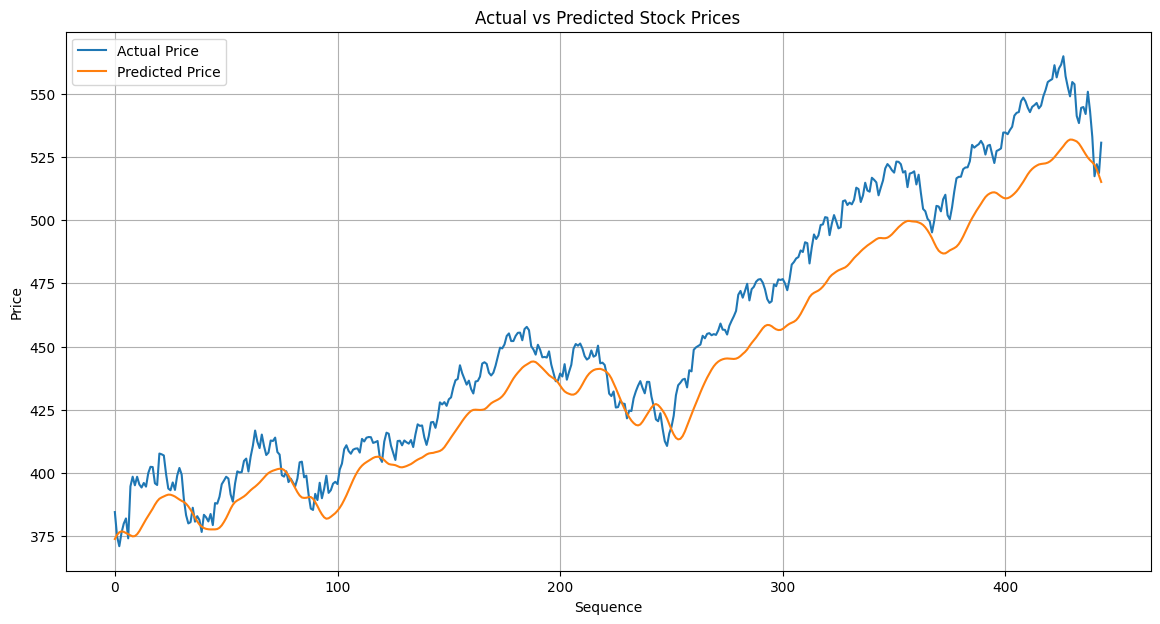

Mean Absolute Error (MAE): 14.487547522192603
Mean Squared Error (MSE): 276.58443317117025
Root Mean Squared Error (RMSE): 16.630827795728337
R-squared (R²): 0.8956477951197298
Huber Loss: 13.990839004516602
1/1 [==============================] - 0s 24ms/step
Next Day Close Price: 512.90
85.71% Negative


In [51]:
main()